In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image  # just for loading images

# Paths
PROJECT_ROOT = Path("..").resolve()
CSV_PATH = PROJECT_ROOT / "data" / "san_leandro_products.csv"
EMBS_PATH = PROJECT_ROOT / "data" / "image_embs.npy"
IMAGES_DIR = PROJECT_ROOT / "images"  # <-- folder with your JPGs

print("CSV:", CSV_PATH)
print("Embeddings:", EMBS_PATH)
print("Images dir:", IMAGES_DIR)

# Load full CSV (all products)
raw_df = pd.read_csv(CSV_PATH)

# Filtered view: only products that have an image file
IMAGE_COL = "image_filename"
if IMAGE_COL not in raw_df.columns:
    raise ValueError(f"{IMAGE_COL!r} column not found in CSV")

df = raw_df[raw_df[IMAGE_COL].notna() & (raw_df[IMAGE_COL] != "")]
df = df.reset_index(drop=True)

print("Full CSV rows:", len(raw_df))
print("Filtered rows with images (used for embeddings):", len(df))
df.head()


CSV: C:\Users\j0sep\Mat-Vis-Net\data\san_leandro_products.csv
Embeddings: C:\Users\j0sep\Mat-Vis-Net\data\image_embs.npy
Images dir: C:\Users\j0sep\Mat-Vis-Net\images
Full CSV rows: 3016
Filtered rows with images (used for embeddings): 1195


,sku,name,category_slug,product_url,image_url,image_filename
0,101156321,Coral Bay Porcelain Matte Tile,/24-x-48-tile-2,https://www.flooranddecor.com/porcelain-tile/c...,https://i8.amplience.net/i/flooranddecor/10115...,101156321.jpg
1,100434463,Ozark Pecan Wood Plank Porcelain Tile,/50-percent-more-slip-resistant-tile,https://www.flooranddecor.com/porcelain-tile/o...,https://i8.amplience.net/i/flooranddecor/10043...,100434463.jpg
2,100905462,Aster Porcelain Tile,/accent-wall-tile,https://www.flooranddecor.com/porcelain-tile/a...,https://i8.amplience.net/i/flooranddecor/10090...,100905462.jpg
3,100961903,Carrara White Marble Side Splash,/bathroom-vanities,https://www.flooranddecor.com/bathroom-vanitie...,https://i8.amplience.net/i/flooranddecor/10096...,100961903.jpg
4,100961887,White Engineered Marble Side Splash,/bathroom-vanities,https://www.flooranddecor.com/bathroom-vanitie...,https://i8.amplience.net/i/flooranddecor/10096...,100961887.jpg


In [2]:
from sklearn.neighbors import NearestNeighbors

image_embs = np.load(EMBS_PATH)
print("image_embs shape:", image_embs.shape)

if image_embs.shape[0] != len(df):
    raise ValueError(
        f"Mismatch between embeddings and df: "
        f"{image_embs.shape[0]} embeddings vs {len(df)} rows in df"
    )

nn = NearestNeighbors(n_neighbors=20, metric="cosine")
nn.fit(image_embs)

print("kNN index built over", image_embs.shape[0], "products")


image_embs shape: (1195, 512)
kNN index built over 1195 products


In [3]:
def get_index_by_sku(query_sku: str) -> int:
    """
    Return the row index in df corresponding to the given SKU.
    Only SKUs present in the filtered df (with embeddings) are valid.
    """
    sku_str = str(query_sku).strip()
    matches = df.index[df["sku"].astype(str).str.strip() == sku_str].tolist()
    if not matches:
        # Check if it's only in the raw CSV but not in the filtered df
        exists_in_raw = raw_df["sku"].astype(str).str.strip().eq(sku_str).any()
        if exists_in_raw:
            raise ValueError(
                f"SKU {sku_str!r} exists in san_leandro_products.csv but "
                "does not have an embedding (likely missing image_filename "
                "in the filtered set)."
            )
        raise ValueError(f"SKU {sku_str!r} not found in san_leandro_products.csv.")
    return matches[0]


def find_index_by_name_substring(substr: str, occurrence: int = 0) -> int:
    """
    Find the index of a product whose name contains the given substring
    (case-insensitive). If multiple matches exist, `occurrence` chooses
    which one (0 = first).
    """
    mask = df["name"].str.contains(substr, case=False, na=False)
    matches = df[mask]
    if matches.empty:
        raise ValueError(f"No products with name containing {substr!r}")
    if occurrence >= len(matches):
        raise ValueError(
            f"Only {len(matches)} matches for {substr!r}, but occurrence={occurrence}"
        )
    return matches.index[occurrence]


def search_similar_by_index(query_idx: int, top_k: int = 5, exclude_same: bool = True):
    """
    Given a row index in df, return the top_k most similar products by image embedding.
    """
    query_vec = image_embs[query_idx].reshape(1, -1)
    distances, indices = nn.kneighbors(query_vec, n_neighbors=top_k + 1)

    dist_list = distances[0].tolist()
    idx_list = indices[0].tolist()

    results = []
    for dist, idx in zip(dist_list, idx_list):
        if exclude_same and idx == query_idx:
            continue

        row = df.iloc[idx]
        results.append(
            {
                "index": int(idx),
                "rank": len(results) + 1,
                "sku": row["sku"],
                "name": row["name"],
                "category_slug": row.get("category_slug"),
                "distance": float(dist),
            }
        )

        if len(results) >= top_k:
            break

    return results


def show_product_image(row, title_prefix: str = ""):
    """
    Display the product image for a given row of df.
    """
    img_name = row.get("image_filename")
    if not isinstance(img_name, str) or not img_name:
        print("No image_filename for this row.")
        return

    img_path = IMAGES_DIR / img_name
    if not img_path.exists():
        print("Image file not found:", img_path)
        return

    img = Image.open(img_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    title = f"{title_prefix}SKU {row['sku']} – {row['name']}"
    plt.title(title, fontsize=8)
    plt.tight_layout()
    plt.show()


def show_results_with_images(query_idx: int, top_k: int = 5):
    """
    Convenience: show query product + top_k similar products with images.
    """
    query_row = df.iloc[query_idx]

    print("QUERY PRODUCT")
    print("SKU:", query_row["sku"])
    print("Name:", query_row["name"])
    print("Category:", query_row.get("category_slug"))
    show_product_image(query_row, title_prefix="QUERY: ")

    results = search_similar_by_index(query_idx, top_k=top_k)

    print("\nSIMILAR PRODUCTS")
    print("----------------")
    for r in results:
        row = df.iloc[r["index"]]
        print(f"Rank {r['rank']} | SKU {r['sku']} | dist={r['distance']:.4f}")
        print("  Name:", r["name"])
        print("  Category:", r["category_slug"])
        show_product_image(row, title_prefix=f"RANK {r['rank']}: ")


In [4]:
query_sku = "101156321"  # change this to a valid SKU from df["sku"]

query_idx = get_index_by_sku(query_sku)
query_row = df.iloc[query_idx]

print("QUERY PRODUCT")
print("SKU:", query_row["sku"])
print("Name:", query_row["name"])
print("Category:", query_row.get("category_slug"))
print()

results = search_similar_by_index(query_idx, top_k=5)

print("SIMILAR PRODUCTS")
print("----------------")
for r in results:
    print(f"Rank {r['rank']} | SKU {r['sku']} | dist={r['distance']:.4f}")
    print("  Name:", r["name"])
    print("  Category:", r["category_slug"])
    print()


QUERY PRODUCT
SKU: 101156321
Name: Coral Bay Porcelain Matte Tile
Category: /24-x-48-tile-2

SIMILAR PRODUCTS
----------------
Rank 1 | SKU 101329332 | dist=0.0038
  Name: Coral Bay Polished Porcelain Tile
  Category: /tile

Rank 2 | SKU 101015998 | dist=0.0826
  Name: Caracal Crossing Waterproof Rigid Core Luxury Vinyl Plank - Cork Pad
  Category: /nucore-flooring

Rank 3 | SKU 101142271 | dist=0.0873
  Name: Giacometti White Polished Porcelain Tile
  Category: /tile

Rank 4 | SKU 101076578 | dist=0.0950
  Name: Pietra Blanco Chiseled Edge Porcelain Paver
  Category: /outdoor-decoratives

Rank 5 | SKU 100434463 | dist=0.1018
  Name: Ozark Pecan Wood Plank Porcelain Tile
  Category: /50-percent-more-slip-resistant-tile



QUERY PRODUCT
SKU: 101156321
Name: Coral Bay Porcelain Matte Tile
Category: /24-x-48-tile-2


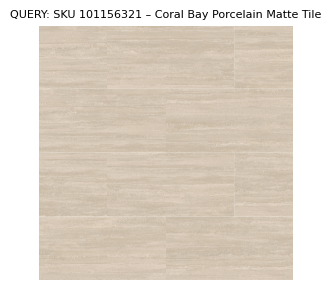


SIMILAR PRODUCTS
----------------
Rank 1 | SKU 101329332 | dist=0.0038
  Name: Coral Bay Polished Porcelain Tile
  Category: /tile


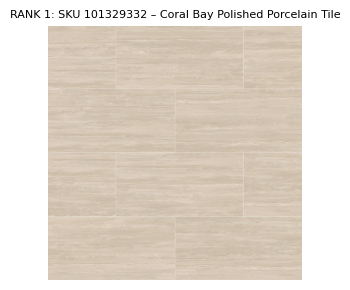

Rank 2 | SKU 101015998 | dist=0.0826
  Name: Caracal Crossing Waterproof Rigid Core Luxury Vinyl Plank - Cork Pad
  Category: /nucore-flooring


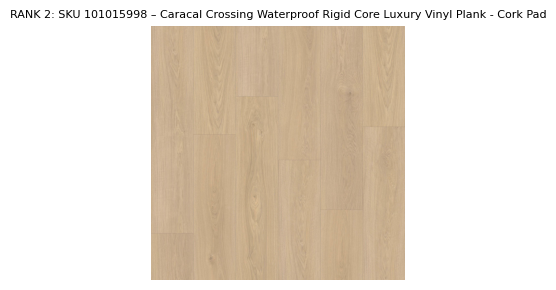

Rank 3 | SKU 101142271 | dist=0.0873
  Name: Giacometti White Polished Porcelain Tile
  Category: /tile


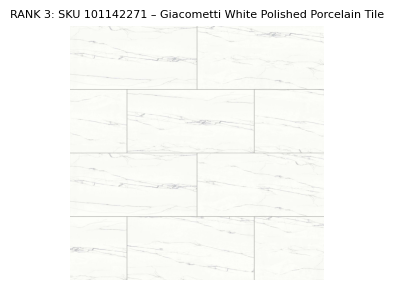

Rank 4 | SKU 101076578 | dist=0.0950
  Name: Pietra Blanco Chiseled Edge Porcelain Paver
  Category: /outdoor-decoratives


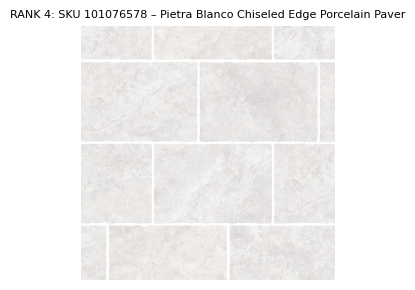

Rank 5 | SKU 100434463 | dist=0.1018
  Name: Ozark Pecan Wood Plank Porcelain Tile
  Category: /50-percent-more-slip-resistant-tile


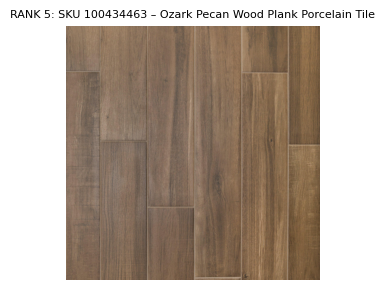

In [5]:
query_sku = "101156321"  # change to a valid SKU from df["sku"]

query_idx = get_index_by_sku(query_sku)
show_results_with_images(query_idx, top_k=5)

In [6]:
query_name_substr = "oak"  # e.g. "oak", "marble", "ledger", etc.
query_idx = find_index_by_name_substring(query_name_substr, occurrence=0)
query_row = df.iloc[query_idx]

print("QUERY PRODUCT (by name substring)")
print("SKU:", query_row["sku"])
print("Name:", query_row["name"])
print("Category:", query_row.get("category_slug"))
print()

results = search_similar_by_index(query_idx, top_k=5)

print("SIMILAR PRODUCTS")
print("----------------")
for r in results:
    print(f"Rank {r['rank']} | SKU {r['sku']} | dist={r['distance']:.4f}")
    print("  Name:", r["name"])
    print("  Category:", r["category_slug"])
    print()


QUERY PRODUCT (by name substring)
SKU: 101019479
Name: Creekside Sawn White Oak Wire-Brushed Engineered Hardwood
Category: /engineered-hardwood-wood

SIMILAR PRODUCTS
----------------
Rank 1 | SKU 100836824 | dist=0.0196
  Name: Pastoral Sawn White Oak Wire-Brushed Engineered Hardwood
  Category: /engineered-hardwood-wood

Rank 2 | SKU 100836808 | dist=0.0259
  Name: Cheshire White Oak Wire-Brushed Sawn Engineered Hardwood
  Category: /engineered-hardwood-wood

Rank 3 | SKU 101015998 | dist=0.0373
  Name: Caracal Crossing Waterproof Rigid Core Luxury Vinyl Plank - Cork Pad
  Category: /nucore-flooring

Rank 4 | SKU 100434463 | dist=0.0412
  Name: Ozark Pecan Wood Plank Porcelain Tile
  Category: /50-percent-more-slip-resistant-tile

Rank 5 | SKU 100511021 | dist=0.0957
  Name: Color 29330P Large Bamboo Flush Stair Nose
  Category: /clearance-installation-materials

